## Important notes: 
Before running this code, please ensures that you have set up the following directory structure:
```
/root
  |-- baseline_logreg_model.ipynb
  |-- /dataset
    |-- train.csv
    |-- test.csv
    |-- /features
        |-- glove.6B.100d.txt
        |-- <any other cached csv files for fast computation>
```

## Loading Dataset

In [2]:
# Load the data from the dataset

import pandas as pd

original_training_df = pd.read_csv("./dataset/train.csv")
original_testing_df = pd.read_csv("./dataset/test.csv")

# don't sample, use the actual data
training_df = original_training_df
testing_df = original_testing_df

original_training_df.shape, original_testing_df.shape

((42702, 5), (16937, 5))

# Feature Engineering

## Empath Features
Empath is a library that provides categorization of text by its sentiment. For example, if we have a text saying that "We have 1 billion USD.", it is likely that the library categorizes this text as "money" related and so on.

In [12]:
from empath import Empath

lexicon = Empath()

desired_categories = ['business', 'economics', 'money', 'tourism', 'shopping', 'leader', 'government', 'banking', 'hiking']

def extract_empath_features(text: str) -> dict:
    return lexicon.analyze(text, categories=desired_categories)

training_empath_features = pd.DataFrame(training_df["Document"].apply(extract_empath_features).tolist())
testing_empath_features = pd.DataFrame(testing_df["Document"].apply(extract_empath_features).tolist())

Since some of the categorization in Empath has very low correlation to the labeling of important and unimportant fact, we only select categories that have higher correlation.

In [112]:
# check correlation of the engineered features with the class
empath_correlation = training_empath_features.corrwith(training_df["Label"])
empath_correlation.sort_values(ascending=False, inplace=True)

empath_correlation

business      0.263896
economics     0.234881
government    0.233978
leader        0.225144
money         0.204439
banking       0.187463
tourism       0.158579
shopping      0.150630
hiking        0.105904
dtype: float64

### (Optional) Get Desired Empath Categories
Below 2 cells show how we find out the categories of interest, as Empath provides 194 categories as default, not all of them give information about the class label, hence we only choose those categories with high correlation.

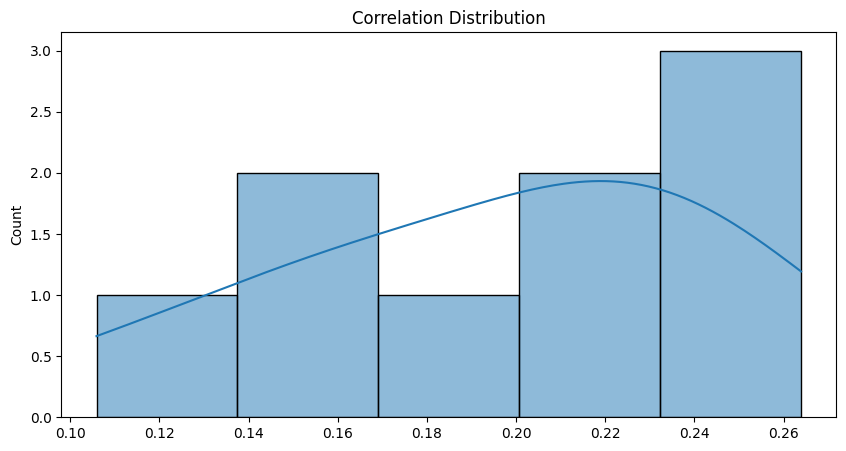

In [113]:
# check distribution of the correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(empath_correlation, kde=True)
plt.title("Correlation Distribution")
plt.show()

In [28]:
# select empath categories with correlation > 0.1
selected_empath_features = empath_correlation[empath_correlation > 0.1].index

selected_training_empath_features = training_empath_features[selected_empath_features]

selected_training_empath_features.columns

Index(['business', 'economics', 'money', 'tourism', 'shopping', 'leader',
       'government', 'banking', 'hiking'],
      dtype='object')

## Complexity Features
Complexity features include most numerical features of a given text. 

In [13]:
def extract_complexity_features(text: str) -> dict:
    complexity_features = {}
    complexity_features["digit_ratio"] = len([char for char in text if char.isdigit()]) / len(text)
    
    return complexity_features
    
training_complexity_features = training_df["Document"].apply(extract_complexity_features).apply(pd.Series)
training_complexity_features["sentence_count"] = training_df["Num_Sentences"]
training_complexity_features["text_length"] = training_df["Document"].apply(len)
training_complexity_features["avg_sentence_length"] = training_complexity_features["text_length"] / training_complexity_features["sentence_count"]

testing_complexity_features = testing_df["Document"].apply(extract_complexity_features).apply(pd.Series)
testing_complexity_features["sentence_count"] = testing_df["Num_Sentences"]
testing_complexity_features["text_length"] = testing_df["Document"].apply(len)
testing_complexity_features["avg_sentence_length"] = testing_complexity_features["text_length"] / testing_complexity_features["sentence_count"]

In [115]:
# check correlation of the engineered features with the class

complexity_correlation = training_complexity_features.corrwith(training_df["Label"])

complexity_correlation = complexity_correlation.sort_values(ascending=False)

complexity_correlation

text_length            0.215251
sentence_count         0.170089
avg_sentence_length    0.150759
digit_ratio            0.112814
special_char_ratio    -0.006241
dtype: float64

## Psycholinguistic Features

In [14]:
from textblob import TextBlob
import spacy
import contractions

nlp = spacy.load("en_core_web_sm")

def extract_psycholinguistic_features(text: str):
    psycholinguistic_features = {}
    
    textBlob = TextBlob(contractions.fix(text))
    psycholinguistic_features["polarity"] = textBlob.sentiment.polarity
    psycholinguistic_features["subjectivity"] = textBlob.sentiment.subjectivity
    
    return psycholinguistic_features

training_psycholinguistic_features = training_df["Document"].apply(extract_psycholinguistic_features).apply(pd.Series)
testing_psycholinguistic_features = testing_df["Document"].apply(extract_psycholinguistic_features).apply(pd.Series)

In [15]:
# check correlation of the engineered features with the class

psycholinguistic_correlation = training_psycholinguistic_features.corrwith(training_df["Label"])

psycholinguistic_correlation = psycholinguistic_correlation.sort_values(ascending=False)

psycholinguistic_correlation

polarity        0.052736
subjectivity   -0.114879
dtype: float64

## Readability Features

In [16]:
import textstat

def extract_readability_features(text):
    readability_features = {}
    
    readability_features["gunning_fog_index"] = textstat.gunning_fog(text)
    readability_features["coleman_liau_index"] = textstat.coleman_liau_index(text)
    readability_features['linsear_write'] = textstat.linsear_write_formula(text)
    
    # Dale-Chall Readability Score
    readability_features['dale_chall_score'] = textstat.dale_chall_readability_score(text)
    
    # Flesch Reading Ease
    readability_features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    
    # Spache Readability Score
    readability_features['spache'] = textstat.spache_readability(text)
    
    # Automated Readability Index
    readability_features['automated_readability_index'] = textstat.automated_readability_index(text)
    
    # Smog Index
    readability_features['smog_index'] = textstat.smog_index(text)
    
    # Flesch-Kincaid Grade Level
    readability_features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    
    # RIX Readability
    readability_features['rix'] = textstat.rix(text)
    
    # McAlpine EFLAW Readability
    readability_features['mcalpine_eflaw'] = textstat.mcalpine_eflaw(text)
    
    # Gulpease Readability
    readability_features['gulpease'] = textstat.gulpease_index(text)
    
    return readability_features

training_readability_features = training_df["Document"].apply(extract_readability_features).apply(pd.Series)
testing_readability_features = testing_df["Document"].apply(extract_readability_features).apply(pd.Series)

In [120]:
# check correlation of the engineered features with the class

readability_correlation = training_readability_features.corrwith(training_df["Label"])

readability_correlation = readability_correlation.sort_values(ascending=False)

readability_correlation

rix                            0.266009
spache                         0.186423
gunning_fog_index              0.176326
flesch_kincaid_grade           0.164256
mcalpine_eflaw                 0.159909
smog_index                     0.146777
linsear_write                  0.146760
automated_readability_index    0.084847
coleman_liau_index             0.040524
dale_chall_score               0.039097
flesch_reading_ease           -0.113816
gulpease                      -0.135295
dtype: float64

## NER Features (Not Used)

The intuition of using NER as features is that it is likely that a sentence that has many NER entities might be an important fact, we want to exploit this property. However, the computation time for NER features are way too long, and it doesn't boost the model performance significantly.

In [86]:
# import nltk

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

# from nltk.tokenize import word_tokenize
# from nltk.tree import Tree

# def extract_ner_features(document: str) -> dict:
#     ner_features = {}
    
#     words = word_tokenize(document)
#     pos_tags = nltk.pos_tag(words)
#     ner_tags = nltk.ne_chunk(pos_tags)
    
#     # obtain total number of entities presented in the document, and total number of unique different entity types
#     entities = []
#     unique_entity_types = set()
    
#     for entity in ner_tags:
#         if type(entity) == Tree:
#             entities.append(" ".join([word for word, tag in entity.leaves()]))
#             unique_entity_types.add(entity.label())
            
#     ner_features["total_entities"] = len(entities)
#     ner_features["unique_entities"] = len(set(entities))
#     ner_features["unique_entity_types"] = len(unique_entity_types)
        
#     return ner_features
                

# training_ner_features = training_df["Document"].apply(extract_ner_features).apply(pd.Series)
# testing_ner_features = testing_df["Document"].apply(extract_ner_features).apply(pd.Series)    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tryyang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tryyang\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\tryyang\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tryyang\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [87]:
# # check correlation of the engineered features with the class

# ner_correlation = training_ner_features.corrwith(training_df["Label"])

# ner_correlation = ner_correlation.sort_values(ascending=False)

# ner_correlation

total_entities         0.201191
unique_entities        0.187495
unique_entity_types    0.151966
dtype: float64

## TF-IDF Features

In [3]:
# tf-idf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import contractions

def preprocess_text(text: str) -> str:
    # fix the text by removing special characters, expand contractions and converting to lowercase
    fixed_text = contractions.fix(text)
    return re.sub(r"[^a-zA-z0-9\s]", "", fixed_text).lower()

# the original tf-idf vector has more than 180k features, which requires a RAM of >50GB to process
# 30k highest frequency words are selected to reduce the feature space, so that it can fit to a 16GB RAM
tf_idf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, stop_words="english", max_features=30000)

tf_idf_vectorizer.fit(training_df["Document"])

training_tf_idf_features = tf_idf_vectorizer.transform(training_df["Document"])
training_tf_idf_features = pd.DataFrame(training_tf_idf_features.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
testing_tf_idf_features = tf_idf_vectorizer.transform(testing_df["Document"])
testing_tf_idf_features = pd.DataFrame(testing_tf_idf_features.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())

training_tf_idf_features.shape, testing_tf_idf_features.shape

((42702, 30000), (16937, 30000))

As TF-IDF features are too sparse and big, one idea is to use SVD technique to extract only important features from it.

In [4]:
# Apply SVD on tf_idf features
from sklearn.decomposition import TruncatedSVD

n_components = 100

svd = TruncatedSVD(n_components=n_components, random_state=42)

training_tf_idf_features = svd.fit_transform(training_tf_idf_features)
testing_tf_idf_features = svd.transform(testing_tf_idf_features)

training_tf_idf_features = pd.DataFrame(training_tf_idf_features, columns=[f"tf_idf_svd_{i}" for i in range(n_components)])
testing_tf_idf_features = pd.DataFrame(testing_tf_idf_features, columns=[f"tf_idf_svd_{i}" for i in range(n_components)])

training_tf_idf_features.shape, testing_tf_idf_features.shape

((42702, 100), (16937, 100))

### (Optional) Write tf-idf SVD-ed features to disk
Simple reason to save computational time required when we rerun the model.

In [7]:
# write the tf_idf SVD-ed features to disk
training_tf_idf_features.to_csv("./dataset/features/training_tf_idf_svd_features.csv", index=False)
testing_tf_idf_features.to_csv("./dataset/features/testing_tf_idf_svd_features.csv", index=False)

In [ ]:
# read the tf_idf SVD-ed features from disk
training_tf_idf_features = pd.read_csv("./dataset/features/training_tf_idf_svd_features.csv")
testing_tf_idf_features = pd.read_csv("./dataset/features/testing_tf_idf_svd_features.csv")

In [5]:
# check correlation of the engineered features with the class
tf_idf_correlation = training_tf_idf_features.corrwith(training_df["Label"])
tf_idf_correlation = tf_idf_correlation.sort_values(ascending=False)

tf_idf_correlation

tf_idf_svd_2     0.443144
tf_idf_svd_1     0.301324
tf_idf_svd_0     0.259585
tf_idf_svd_3     0.248099
tf_idf_svd_4     0.192920
                   ...   
tf_idf_svd_10   -0.064942
tf_idf_svd_6    -0.079798
tf_idf_svd_7    -0.088049
tf_idf_svd_14   -0.120472
tf_idf_svd_16   -0.177082
Length: 100, dtype: float64

## GloVe
GloVe is a dictionary of pre-trained word embeddings, taking the pre-computed word embeddings and extract features on top of them significantly help improve the model performance.

In [8]:
import numpy as np

def load_glove_embeddings():
    embedding_dict = dict()
    with open("./dataset/features/glove.6B.100d.txt", "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype="float32")
            embedding_dict[word] = vectors
            
    return embedding_dict

glove_embeddings = load_glove_embeddings()

In [9]:
import nltk

nltk.download("punkt")
nltk.download("wordnet")

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions

glove_dimensions = 100
lemmatizer = WordNetLemmatizer()


def tokenize_text(document: str) -> list:
    # remove special characters, expand contractions and convert to lowercase
    text = contractions.fix(document)
    text = re.sub(r"[^a-zA-z0-9\s]", "", text).lower()

    tokens = word_tokenize(text)
    
    # lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens


def get_word_embedding(word: str) -> np.ndarray:
    return glove_embeddings.get(word, np.zeros(glove_dimensions))


def extract_embedding_features(document: str) -> pd.DataFrame:
    tokens = tokenize_text(document)
    embeddings = [get_word_embedding(token) for token in tokens]
    
    # compute the embedding features, cast to Series and give proper column names
    avg_embedding = pd.Series(np.mean(embeddings, axis=0), index=[f"avg_embedding_{i}" for i in range(glove_dimensions)])
    total_embedding = pd.Series(np.sum(embeddings, axis=0), index=[f"total_embedding_{i}" for i in range(glove_dimensions)])
    # below are tried features, though they do not help much
    # min_embedding = pd.Series(np.min(embeddings, axis=0), index=[f"min_embedding_{i}" for i in range(glove_dimensions)])
    # max_embedding = pd.Series(np.max(embeddings, axis=0), index=[f"max_embedding_{i}" for i in range(glove_dimensions)])
    
    return pd.concat([avg_embedding, total_embedding])
    

training_embedding_features = training_df["Document"].apply(extract_embedding_features)
testing_embedding_features = testing_df["Document"].apply(extract_embedding_features)

training_embedding_features.shape, testing_embedding_features.shape


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tryyang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tryyang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


((42702, 200), (16937, 200))

### (Optional) Write embedding features to disk
Simple reason to save computational time on rerun.

In [11]:
# write the embedding features to disk
training_embedding_features.to_csv("./dataset/features/training_embedding_features.csv", index=False)
testing_embedding_features.to_csv("./dataset/features/testing_embedding_features.csv", index=False)

In [10]:
# check correlation of the engineered features with the class
embedding_correlation = training_embedding_features.corrwith(training_df["Label"])
embedding_correlation = embedding_correlation.sort_values(ascending=False)

embedding_correlation

avg_embedding_95      0.394225
total_embedding_95    0.345192
total_embedding_4     0.335838
avg_embedding_4       0.326824
total_embedding_23    0.312639
                        ...   
total_embedding_92   -0.311377
total_embedding_25   -0.325668
avg_embedding_25     -0.332775
avg_embedding_66     -0.352065
avg_embedding_5      -0.366997
Length: 200, dtype: float64

## Combining all extracted features

In [17]:
# combine all the features
feature_df = pd.concat([training_empath_features, training_complexity_features, training_psycholinguistic_features, training_readability_features, training_tf_idf_features, training_embedding_features], axis=1)
X_test = pd.concat([testing_empath_features, testing_complexity_features, testing_psycholinguistic_features, testing_readability_features, testing_tf_idf_features, testing_embedding_features], axis=1)

feature_df.shape, X_test.shape

((42702, 327), (16937, 327))

In [97]:
# check correlation of the engineered features with the class
feature_correlation = feature_df.corrwith(training_df["Label"])
feature_correlation = feature_correlation.sort_values(ascending=False)

feature_correlation

tf_idf_svd_2          0.387965
avg_embedding_4       0.374160
avg_embedding_95      0.354805
total_embedding_95    0.326761
total_embedding_4     0.323606
                        ...   
avg_embedding_41     -0.308806
total_embedding_25   -0.314053
avg_embedding_25     -0.318876
avg_embedding_5      -0.328183
avg_embedding_66     -0.349313
Length: 331, dtype: float64

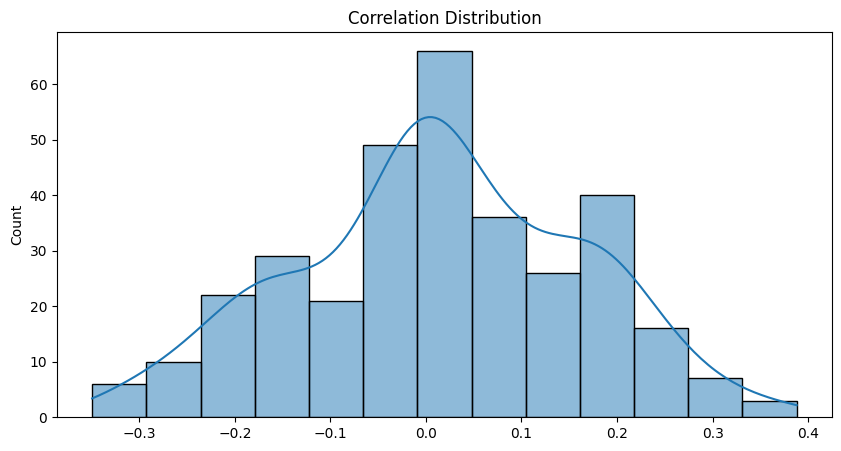

In [98]:
# check distribution of the correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(feature_correlation, kde=True)
plt.title("Correlation Distribution")
plt.show()

## Scaling

In [18]:
# scale the features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# scale each feature individually
feature_df = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_df.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Randomization

Randomize the data so that the model does not become bias as same labeled data are always coming together.

In [19]:
# randomise the data, need a restorable state

feature_df["Label"] = training_df["Label"]

feature_df = feature_df.sample(frac=1, random_state=42)

training_labels = feature_df["Label"]
feature_df.drop(columns=["Label"], inplace=True)

feature_df

,business,economics,money,tourism,shopping,leader,government,banking,hiking,digit_ratio,...,total_embedding_90,total_embedding_91,total_embedding_92,total_embedding_93,total_embedding_94,total_embedding_95,total_embedding_96,total_embedding_97,total_embedding_98,total_embedding_99
5707,-0.409907,-0.443741,-0.430539,-0.346891,-0.346902,-0.361122,-0.409534,-0.394875,-0.250941,-0.479928,...,-0.581458,0.165146,0.299226,-0.406522,0.471968,0.040560,0.332775,0.508413,-0.388488,-0.633118
38275,-0.630539,-0.443741,-0.430539,-0.346891,-0.346902,-0.621236,-0.615398,-0.394875,-0.250941,1.202080,...,-0.392447,0.759544,0.805084,-0.757806,0.868212,-0.194755,0.781128,0.798376,-0.851656,-0.657634
17135,-0.409907,-0.443741,-0.430539,-0.346891,-0.346902,-0.101007,-0.409534,-0.394875,-0.250941,-0.330646,...,1.120246,-0.527049,-0.292402,0.991895,0.170212,1.097289,0.102927,0.127524,-0.065370,-0.435125
28153,1.796414,0.955507,0.062036,0.562883,0.917634,1.199565,2.678426,0.204044,-0.250941,-0.351122,...,1.627744,-1.656001,-1.984018,0.176401,-1.136712,1.186867,-0.507290,-0.641083,1.218008,-0.279511
13014,1.134518,0.489091,2.278624,3.292208,2.814438,4.581052,2.678426,1.102422,1.454291,0.088143,...,0.915869,-0.550798,-3.586727,2.259099,-2.927428,0.608248,-4.711948,-3.695820,2.816977,1.025335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.472621,0.022675,0.554611,-0.346891,-0.346902,-0.621236,-0.615398,0.503503,-0.250941,-0.527059,...,-0.347281,-0.020693,1.052114,-0.469572,0.270153,-0.639116,0.371098,0.188490,-0.529388,0.086041
11284,1.355150,1.888339,2.278624,-0.346891,0.285366,0.939450,2.060834,3.198639,-0.250941,-0.420923,...,1.009295,-1.792259,-1.369813,0.809102,-0.994842,3.669635,-0.704776,-1.529983,1.314350,2.041753
38158,-0.409907,-0.443741,0.062036,-0.346891,0.285366,-0.621236,-0.615398,-0.095416,-0.250941,-0.527059,...,-0.423755,0.794093,0.776797,-0.852988,0.872500,-0.171602,0.806898,0.788114,-0.886160,-0.630098
860,-0.630539,-0.443741,-0.184251,-0.346891,-0.346902,-0.361122,-0.615398,-0.394875,-0.250941,-0.527059,...,-0.174480,-0.127156,0.433671,-0.020524,0.233267,-0.746057,-0.012515,0.239605,-0.354118,-0.032658


## Model Training

### Logistic Regression

In [21]:
# Train a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X_train, y_train = feature_df, training_labels

logistic_model = LogisticRegression(random_state=42, C=1, max_iter=500)

logistic_model.fit(X_train, y_train)

# evaluate the model

# use k-fold cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring="f1_macro")

print("Cross validation macro-averaged F1-score:", scores)
print("Mean macro-averaged F1-score", np.average(scores))

# evaluate the F1-score on the testing set
y_pred = logistic_model.predict(X_test)

# compute the F1-score
test_f1_score = f1_score(testing_df["Label"], y_pred, average="macro")
print("Test macro-averaged F1-score:", test_f1_score)

Cross validation macro-averaged F1-score: [0.89961358 0.9082364  0.90392635 0.90253436 0.90252025]
Mean macro-averaged F1-score 0.903366186253859
Test macro-averaged F1-score: 0.9774656054981723
